###RELEVANT IMPORTS


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import zscore
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, KFold

pd.set_option('display.float_format', lambda x: '%.2f' % x)

###Loading and reading in data files into separate dataframes

In [ ]:
consumer_prices_indicators = pd.read_csv("/content/drive/MyDrive/ML Coursework Dataset/Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv")
crops_production_indicators = pd.read_csv("/content/drive/MyDrive/ML Coursework Dataset/Crops production indicators - FAOSTAT_data_en_2-22-2024.csv")
emissions = pd.read_csv("/content/drive/MyDrive/ML Coursework Dataset/Emissions - FAOSTAT_data_en_2-27-2024.csv")
employment = pd.read_csv("/content/drive/MyDrive/ML Coursework Dataset/Employment - FAOSTAT_data_en_2-27-2024.csv")
exchange_rate = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Exchange rate - FAOSTAT_data_en_2-22-2024.csv")
fertilizers_use = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Fertilizers use - FAOSTAT_data_en_2-27-2024.csv")
food_balances = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Food balances indicators - FAOSTAT_data_en_2-22-2024.csv")
food_security = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Food security indicators  - FAOSTAT_data_en_2-22-2024.csv")
food_trade = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Food trade indicators - FAOSTAT_data_en_2-22-2024.csv")
foreign_investment = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv")
land_temperature = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Land temperature change - FAOSTAT_data_en_2-27-2024.csv")
land_use = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Land use - FAOSTAT_data_en_2-22-2024.csv")
pesticides_use = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Pesticides use - FAOSTAT_data_en_2-27-2024.csv")

<ipython-input-2-4a35648f8022>:12: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use = pd.read_csv ("/content/drive/MyDrive/ML Coursework Dataset/Land use - FAOSTAT_data_en_2-22-2024.csv")


###Assessing the structure and quality of each file:



In [ ]:
# List of datasets for easy iteration
datasets = {
    "Consumer Prices": consumer_prices_indicators,
    "Crops Production": crops_production_indicators,
    "Emissions": emissions,
    "Employment": employment,
    "Exchange Rate": exchange_rate,
    "Fertilizers Use": fertilizers_use,
    "Food Balances": food_balances,
    "Food Security": food_security,
    "Food Trade": food_trade,
    "Foreign Investment": foreign_investment,
    "Land Temperature": land_temperature,
    "Land Use": land_use,
    "Pesticides Use": pesticides_use
}

# Quick inspection of each dataset
for name, dataset in datasets.items():
    print(f"--- {name} ---")
    print(dataset.info())
    print(dataset.describe())
    print("\n")

--- Consumer Prices ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112890 entries, 0 to 112889
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain Code       112890 non-null  object 
 1   Domain            112890 non-null  object 
 2   Area Code (M49)   112890 non-null  int64  
 3   Area              112890 non-null  object 
 4   Year Code         112890 non-null  int64  
 5   Year              112890 non-null  int64  
 6   Item Code         112890 non-null  int64  
 7   Item              112890 non-null  object 
 8   Months Code       112890 non-null  int64  
 9   Months            112890 non-null  object 
 10  Element Code      112890 non-null  int64  
 11  Element           112890 non-null  object 
 12  Unit              55227 non-null   object 
 13  Value             112890 non-null  float64
 14  Flag              112890 non-null  object 
 15  Flag Description  112890 non-null  object 
 

### Cleaning the Data

In [ ]:
# Define a function to clean data by dropping duplicate rows

def clean_data(df):
    df.drop_duplicates(inplace=True)

# Apply cleaning function to each dataset
for dataset in datasets.values():
    clean_data(dataset)


#Checking the number of rows in each DataFrame after cleaning
for name, dataset in datasets.items():
    print(f"{name} has {len(dataset)} rows after cleaning.")


Consumer Prices has 112890 rows after cleaning.
Crops Production has 41649 rows after cleaning.
Emissions has 28910 rows after cleaning.
Employment has 5917 rows after cleaning.
Exchange Rate has 103276 rows after cleaning.
Fertilizers Use has 17807 rows after cleaning.
Food Balances has 148041 rows after cleaning.
Food Security has 36512 rows after cleaning.
Food Trade has 141738 rows after cleaning.
Foreign Investment has 12276 rows after cleaning.
Land Temperature has 54810 rows after cleaning.
Land Use has 97995 rows after cleaning.
Pesticides Use has 35202 rows after cleaning.


##Food Trade Indicators




In [ ]:
# Display the first few rows of dataframe
print(food_trade.head())

# Selecting the relevant columns directly
refined_food_trade = food_trade[['Year', 'Area', 'Item', 'Element', 'Value']]

# Pivot the DataFrame to create separate columns for 'Import Value' and 'Export Value'
food_trade_pivot = refined_food_trade.pivot_table(index=['Year', 'Area', 'Item'],
                                                  columns='Element',
                                                  values='Value',
                                                  aggfunc='sum').reset_index()

# Reset the column names to remove the hierarchy
food_trade_pivot.columns.name = None

# Drop rows where either 'Export Value' or 'Import Value' is NaN
food_trade_pivot.dropna(subset=['Export Value', 'Import Value'], inplace=True)

# Creating a new column 'Future Export Value' that shifts the 'Export Value' three years ahead
food_trade_pivot['Future Export Value'] = food_trade_pivot.groupby(['Area', 'Item'])['Export Value'].shift(-3)

# Drop rows with NaN values in the lag columns
food_trade_pivot.dropna(subset=['Future Export Value'], inplace=True)

# Print the first few rows to inspect the result of preprocessing
print(food_trade_pivot.head())


  Domain Code                        Domain  Area Code (M49)         Area  \
0         TCL  Crops and livestock products                4  Afghanistan   
1         TCL  Crops and livestock products                4  Afghanistan   
2         TCL  Crops and livestock products                4  Afghanistan   
3         TCL  Crops and livestock products                4  Afghanistan   
4         TCL  Crops and livestock products                4  Afghanistan   

   Element Code       Element Item Code (CPC)                      Item  \
0          5622  Import Value           F1888  Cereals and Preparations   
1          5622  Import Value           F1888  Cereals and Preparations   
2          5622  Import Value           F1888  Cereals and Preparations   
3          5622  Import Value           F1888  Cereals and Preparations   
4          5622  Import Value           F1888  Cereals and Preparations   

   Year Code  Year      Unit    Value Flag Flag Description  Note  
0       1991  1991

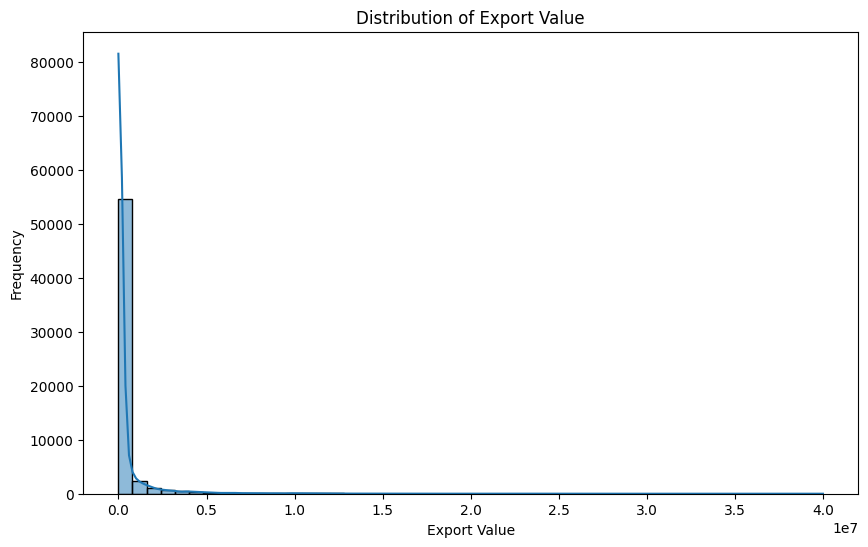

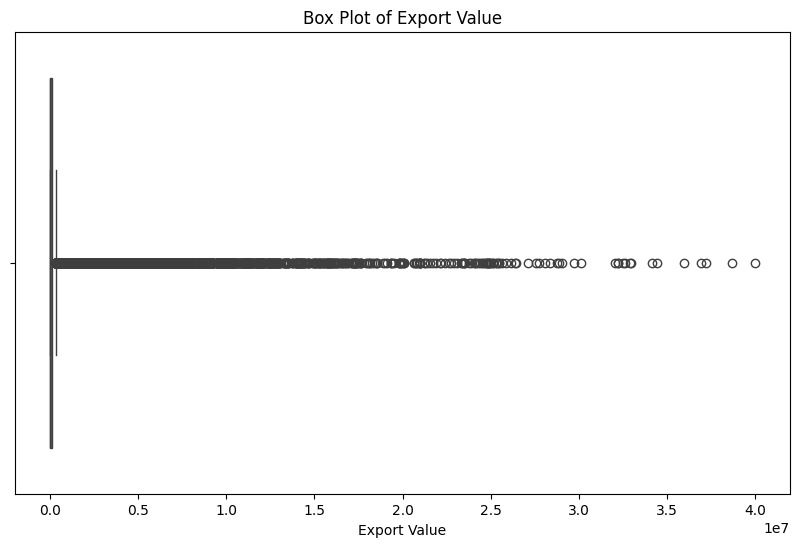

In [ ]:
# Visualize the distribution of 'Export Value'
plt.figure(figsize=(10, 6))
sns.histplot(food_trade_pivot['Export Value'], bins=50, kde=True)
plt.title('Distribution of Export Value')
plt.xlabel('Export Value')
plt.ylabel('Frequency')
plt.show()

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=food_trade_pivot['Export Value'])
plt.title('Box Plot of Export Value')
plt.xlabel('Export Value')
plt.show()

In [ ]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df, column_name):
    """
    Remove outliers from a DataFrame using the IQR method.
    :param df: DataFrame containing the data
    :param column_name: Column name for which to remove outliers
    :return: DataFrame with outliers removed
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to remove outliers from 'Export Value'
food_export_clean = remove_outliers_iqr(food_trade_pivot, 'Export Value')

# Print the number of rows before and after outlier removal
print(f"Number of rows before outlier removal: {len(food_trade_pivot)}")
print(f"Number of rows after outlier removal: {len(food_export_clean)}")

# Display the first few rows of the cleaned df
print(food_export_clean.head())


Number of rows before outlier removal: 60594
Number of rows after outlier removal: 50718
    Year         Area                  Item  Export Value  Import Value  \
4   1991  Afghanistan  Fruit and Vegetables      51858.00        360.00   
8   1991  Afghanistan              Non-food      45055.00      12000.00   
9   1991  Afghanistan            Other food       1330.00      26360.00   
10  1991  Afghanistan       Sugar and Honey          0.00       4900.00   
11  1991  Afghanistan               Tobacco          0.00      12000.00   

    Future Export Value  
4              26907.00  
8              22800.00  
9                650.00  
10                 0.00  
11                 0.00  


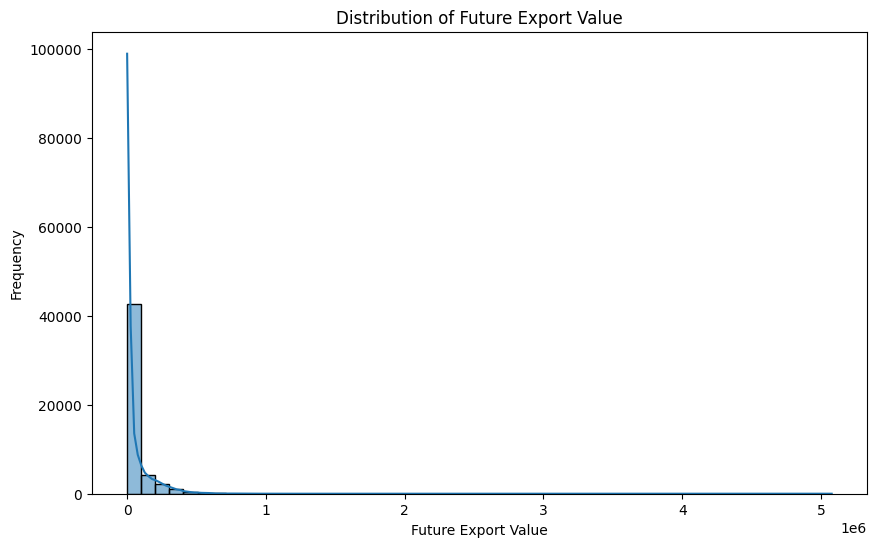

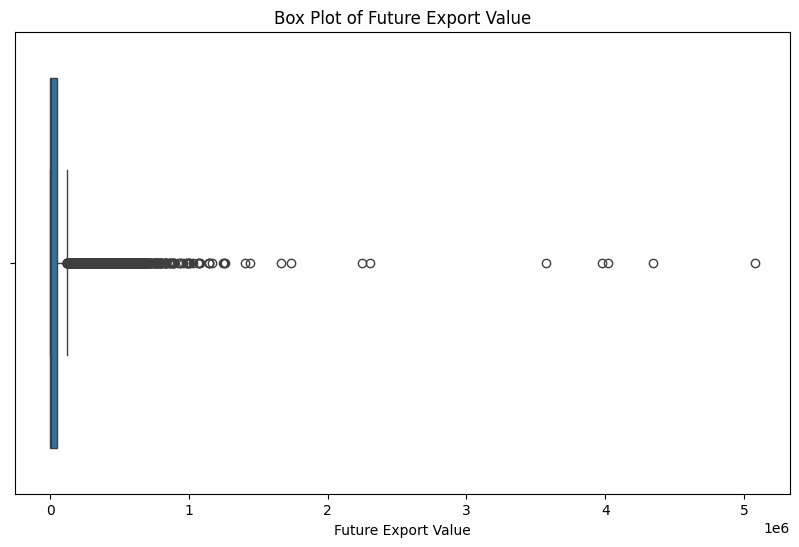

In [ ]:
# Visualize the distribution of 'Future Export Value'
plt.figure(figsize=(10, 6))
sns.histplot(food_export_clean['Future Export Value'], bins=50, kde=True)
plt.title('Distribution of Future Export Value')
plt.xlabel('Future Export Value')
plt.ylabel('Frequency')
plt.show()

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=food_export_clean['Future Export Value'])
plt.title('Box Plot of Future Export Value')
plt.xlabel('Future Export Value')
plt.show()

In [ ]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df, column_name):
    """
    Remove outliers from a DataFrame using the IQR method.
    :param df: DataFrame containing the data
    :param column_name: Column name for which to remove outliers
    :return: DataFrame with outliers removed
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to remove outliers from 'Future Export Value'
food_trade_clean = remove_outliers_iqr(food_export_clean, 'Future Export Value')

# Print the number of rows before and after outlier removal
print(f"Number of rows before outlier removal: {len(food_export_clean)}")
print(f"Number of rows after outlier removal: {len(food_trade_clean)}")

# Display the first few rows of the cleaned DataFrame
print(food_trade_clean.head())


Number of rows before outlier removal: 50718
Number of rows after outlier removal: 43871
    Year         Area                  Item  Export Value  Import Value  \
4   1991  Afghanistan  Fruit and Vegetables      51858.00        360.00   
8   1991  Afghanistan              Non-food      45055.00      12000.00   
9   1991  Afghanistan            Other food       1330.00      26360.00   
10  1991  Afghanistan       Sugar and Honey          0.00       4900.00   
11  1991  Afghanistan               Tobacco          0.00      12000.00   

    Future Export Value  
4              26907.00  
8              22800.00  
9                650.00  
10                 0.00  
11                 0.00  


SOME VISUALIZATIONS

Correlation Matrix between 'Import Value' and 'Future Export Value':                      Import Value  Future Export Value
Import Value                 1.00                 0.22
Future Export Value          0.22                 1.00


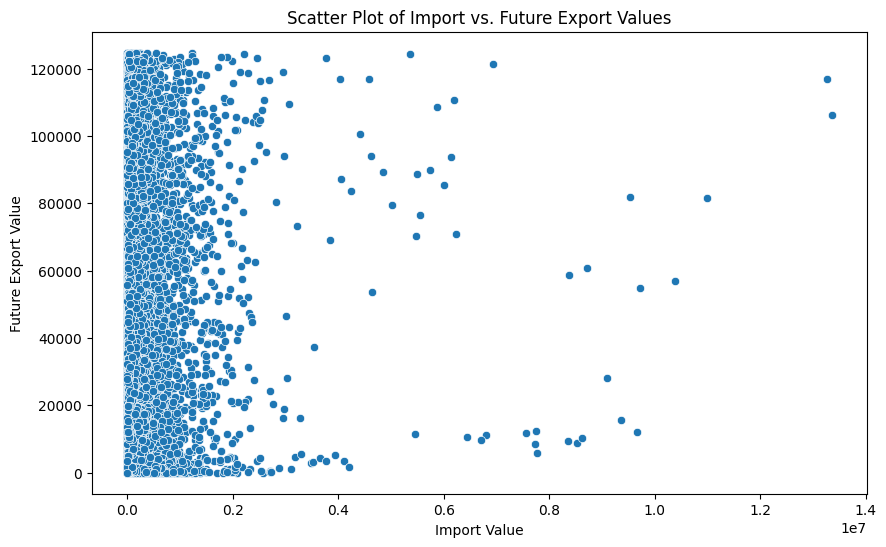

In [ ]:
# Print correlation matrix between Import Value & Export Value for potential feture selection
print("Correlation Matrix between 'Import Value' and 'Future Export Value':", (food_trade_clean[['Import Value', 'Future Export Value']].corr()))


# Generate a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Import Value', y='Future Export Value', data=food_trade_clean)
plt.title('Scatter Plot of Import vs. Future Export Values')
plt.xlabel('Import Value')
plt.ylabel('Future Export Value')
plt.show()

###Understanding historical trends

Historical data visualizations establish a baseline to compare against the model's forecasts, providing a qualitative measure of the model's predictive accuracy.
The graphs provide a clear visual representation of how export values for specific items have evolved over time in these countries. This is crucial for:

Detecting Anomalies: Sharp increases or decreases could indicate external influences or data anomalies that need to be investigated.


In [ ]:
#Items and countries listed in the df
print('List of all Countries:', food_trade_clean['Area'].unique())
print('List of all Crops:', food_trade_clean['Item'].unique())
print('Years of Data Available:',food_trade_clean['Year'].unique())

List of all Countries: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Australia' 'Austria' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belgium-Luxembourg' 'Belize' 'Benin' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Botswana' 'Brazil'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'China, Hong Kong SAR' 'China, Macao SAR'
 'China, Taiwan Province of' 'China, mainland' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Cuba' 'Cyprus' "Côte d'Ivoire"
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eswatini' 'Faroe Islands' 'Fiji' 'Finland' 'France' 'French Polynesia'
 'Gabon' 'Gambia' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India'
 

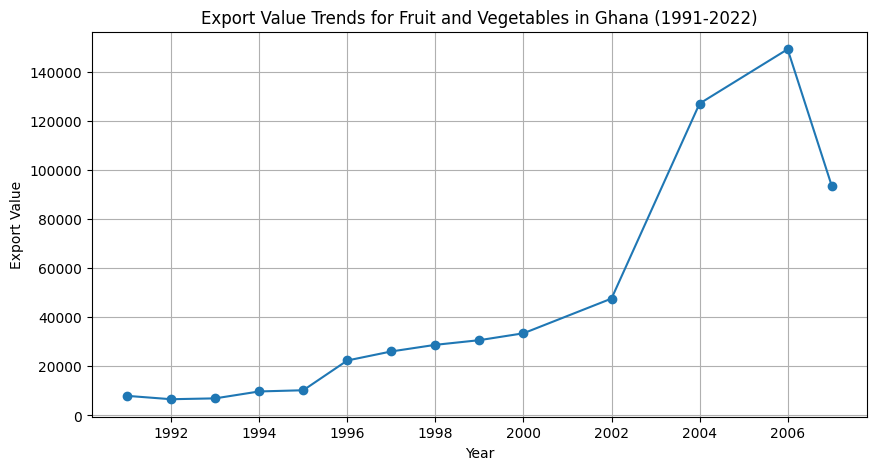

In [ ]:
def plot_export_values(data, area, item):
    """
    Plots the export value trends for a specified country and item over time.

    Parameters:
    - data: DataFrame containing the trade data.
    - area: The country to filter the data.
    - item: The trade crop to filter the data.
    """
    # Filter data based on area and item
    sample_data = data[(data['Area'] == area) & (data['Item'] == item)]

    # Plotting the export values
    plt.figure(figsize=(10, 5))
    plt.plot(sample_data['Year'], sample_data['Export Value'], marker='o', linestyle='-')
    plt.title(f'Export Value Trends for {item} in {area} (1991-2022)')
    plt.xlabel('Year')
    plt.ylabel('Export Value')
    plt.grid(True)
    plt.show()

# Example usage of the function:
plot_export_values(food_trade_clean, 'Ghana', 'Fruit and Vegetables')


Feature Engineering: INTRODUCING LAG FEATURES

Temporal Patterns: By analyzing three years of historical data as features, the model can capture and learn from annual cyclical patterns, trends, and other temporal dynamics that are likely to influence future values.



In [ ]:
# Ensure the data is sorted by 'Area', 'Item', and 'Year' to accurately shift values
food_trade_clean.sort_values(by=['Area', 'Item', 'Year'], inplace=True)

# Create lag feature for 3 years back
food_trade_clean['Export_Value_Lag_3'] = food_trade_clean.groupby(['Area', 'Item'])['Export Value'].shift(3)

# Drop rows with NaN values in the lag columns
food_trade_clean.dropna(subset=['Export_Value_Lag_3'], inplace=True)


#Display updated df
print(food_trade_clean.head())

# Check the correlation between lag features and the target variable
correlation_matrix = food_trade_clean[[f'Export_Value_Lag_3'] + ['Future Export Value']].corr()
print(correlation_matrix)


       Year         Area                      Item  Export Value  \
62275  2018  Afghanistan       Alcoholic Beverages         30.94   
48210  2012  Afghanistan  Cereals and Preparations          0.00   
50554  2013  Afghanistan  Cereals and Preparations          0.00   
52898  2014  Afghanistan  Cereals and Preparations       1074.45   
55241  2015  Afghanistan  Cereals and Preparations        173.08   

       Import Value  Future Export Value  Export_Value_Lag_3  
62275       5908.79                 1.11               39.04  
48210     372176.00               173.08               15.00  
50554     419030.00               346.57               54.00  
52898     815313.48              1628.89                0.00  
55241     768582.62               591.29                0.00  
                     Export_Value_Lag_3  Future Export Value
Export_Value_Lag_3                 1.00                 0.70
Future Export Value                0.70                 1.00


<ipython-input-13-3aa96728d53f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_trade_clean.sort_values(by=['Area', 'Item', 'Year'], inplace=True)
<ipython-input-13-3aa96728d53f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_trade_clean['Export_Value_Lag_3'] = food_trade_clean.groupby(['Area', 'Item'])['Export Value'].shift(3)
<ipython-input-13-3aa96728d53f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

##Food Balance Indicators

In [ ]:
print("Basic DataFrame Information:")
food_balances.info()

# Display the first few rows of the DataFrame
print("\nPreview of DataFrame:")
print(food_balances.head())

# Check for missing values across all columns
print("\nMissing Values Check:")
print(food_balances.isnull().sum())

Basic DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148041 entries, 0 to 148040
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain Code       148041 non-null  object 
 1   Domain            148041 non-null  object 
 2   Area Code (M49)   148041 non-null  int64  
 3   Area              148041 non-null  object 
 4   Element Code      148041 non-null  int64  
 5   Element           148041 non-null  object 
 6   Item Code (FBS)   148041 non-null  object 
 7   Item              148041 non-null  object 
 8   Year Code         148041 non-null  int64  
 9   Year              148041 non-null  int64  
 10  Unit              148041 non-null  object 
 11  Value             148041 non-null  float64
 12  Flag              148041 non-null  object 
 13  Flag Description  148041 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 15.8+ MB

Preview of DataFrame:
  Doma

In [ ]:
# Pivot the data

# Filter to keep only rows where 'Element' is 'Import Quantity' or 'Export Quantity'
relevant_data = food_balances[(food_balances['Element'] == 'Import Quantity') | (food_balances['Element'] == 'Export Quantity')]

food_balances_pivot = relevant_data.pivot_table(
    index=['Year', 'Area', 'Item'],  # Columns to keep and not spread
    columns='Element',  # Column to spread
    values='Value',  # Values to use to fill in the new columns
    aggfunc='sum'  # Aggregation function to use
).reset_index()

# Reset index to flatten the DataFrame after pivoting
food_balances_pivot.reset_index(inplace=True)


# Check for missing values
print(food_balances_pivot.isnull().sum())


Element
index                 0
Year                  0
Area                  0
Item                  0
Export Quantity    2697
Import Quantity     192
dtype: int64


In [ ]:
# Drop rows where either 'Import_Qty' or 'Export_Qty' is NaN
food_balances_pivot.dropna(subset=['Import Quantity', 'Export Quantity'], inplace=True)

print('Clean Food Balances:')
print(food_balances_pivot.head())

Clean Food Balances:
Element  index  Year         Area                      Item  Export Quantity  \
1            1  2010  Afghanistan  Cereals - Excluding Beer             0.00   
3            3  2010  Afghanistan             Fish, Seafood             0.00   
4            4  2010  Afghanistan   Fruits - Excluding Wine           158.00   
6            6  2010  Afghanistan   Milk - Excluding Butter             0.00   
7            7  2010  Afghanistan                  Oilcrops            15.00   

Element  Import Quantity  
1                2000.00  
3                   0.01  
4                 176.00  
6                 132.00  
7                   0.00  


In [ ]:
#Items and countries listed in df
print('List of all Countries:', food_balances_pivot['Area'].unique())

print('List of all Crops:', food_balances_pivot['Item'].unique())

print('Years of Data Available:',food_balances_pivot['Year'].unique())

List of all Countries: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'China, Hong Kong SAR' 'China, Macao SAR' 'China, Taiwan Province of'
 'China, mainland' 'Colombia' 'Comoros' 'Congo' 'Costa Rica' 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' "Côte d'Ivoire"
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Eswatini'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hungary' '

NB: Years Available: 2010-2021 - NOT ENOUGH DATA TO BE INCORPORTED AS FEATURES

## Crops Production Indicators


In [ ]:
print(crops_production_indicators.head())

print("\nSummary Statistics of crops_production_indicators:")
print(crops_production_indicators.describe())

print("Basic DataFrame Information:")
crops_production_indicators.info()

# Display the first few rows of the DataFrame
print("\nPreview of DataFrame:")
print(crops_production_indicators.head())

# Check for missing values across all columns
print("\nMissing Values Check:")
print(crops_production_indicators.isnull().sum())



  Domain Code                        Domain  Area Code (M49)         Area  \
0         QCL  Crops and livestock products                4  Afghanistan   
1         QCL  Crops and livestock products                4  Afghanistan   
2         QCL  Crops and livestock products                4  Afghanistan   
3         QCL  Crops and livestock products                4  Afghanistan   
4         QCL  Crops and livestock products                4  Afghanistan   

   Element Code Element Item Code (CPC)              Item  Year Code  Year  \
0          5419   Yield           F1717  Cereals, primary       2000  2000   
1          5419   Yield           F1717  Cereals, primary       2001  2001   
2          5419   Yield           F1717  Cereals, primary       2002  2002   
3          5419   Yield           F1717  Cereals, primary       2003  2003   
4          5419   Yield           F1717  Cereals, primary       2004  2004   

       Unit  Value Flag Flag Description  Note  
0  100 g/ha   8063 

In [ ]:
# Filter out rows where Element is 'Yield'
yield_data = crops_production_indicators[crops_production_indicators['Element'] == 'Yield']

# Reshape and rename 'Value' to corresponds to the yield value
yield_data = yield_data[['Area', 'Item', 'Year', 'Value']]
yield_data.rename(columns={'Value': 'Yield'}, inplace=True)  # Rename for clarity

print("Yield Data Preview:")
print(yield_data.head())


Yield Data Preview:
          Area              Item  Year  Yield
0  Afghanistan  Cereals, primary  2000   8063
1  Afghanistan  Cereals, primary  2001  10067
2  Afghanistan  Cereals, primary  2002  16698
3  Afghanistan  Cereals, primary  2003  14580
4  Afghanistan  Cereals, primary  2004  13348


CHECK FOR COMPATIBILITY BETWEEN DATAFRAMES BEFORE MERGING

In [ ]:
print(yield_data['Item'].unique())
print(food_trade_pivot['Item'].unique())

print(yield_data['Year'].unique())
print(food_trade_pivot['Year'].unique())

['Cereals, primary' 'Citrus Fruit, Total' 'Fibre Crops, Fibre Equivalent'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses, Total' 'Roots and Tubers, Total' 'Sugar Crops Primary'
 'Treenuts, Total' 'Vegetables Primary']
['Fruit and Vegetables' 'Non-food' 'Other food' 'Sugar and Honey'
 'Tobacco' 'Alcoholic Beverages' 'Cereals and Preparations'
 'Fats and Oils (excluding Butter)' 'Meat and Meat Preparations'
 'Dairy Products and Eggs' 'Non-alcoholic Beverages'
 'Non-edible Fats and Oils']
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019]


In [ ]:
item_mapping = {
    'Cereals, primary': 'Cereals and Preparations',
    'Citrus Fruit, Total': 'Fruit and Vegetables',
    'Fibre Crops, Fibre Equivalent': 'Other food',
    'Fruit Primary': 'Fruit and Vegetables',
    'Oilcrops, Cake Equivalent': 'Fats and Oils (excluding Butter)',
    'Oilcrops, Oil Equivalent': 'Fats and Oils (excluding Butter)',
    'Pulses, Total': 'Other food',
    'Roots and Tubers, Total': 'Other food',
    'Sugar Crops Primary': 'Sugar and Honey',
    'Treenuts, Total': 'Other food',
    'Vegetables Primary': 'Fruit and Vegetables'
}

# Map the item names in the food_balances dataset
yield_data['Mapped Item'] = yield_data['Item'].map(item_mapping)

# Verify Mapping
print(yield_data['Mapped Item'].unique())

# Drop the 'Item' column
yield_data.drop('Item', axis=1, inplace=True)

# Rename 'Mapped Item' to 'Item'
yield_data.rename(columns={'Mapped Item': 'Item'}, inplace=True)
print(yield_data.columns)

print(yield_data.head())


['Cereals and Preparations' 'Fruit and Vegetables' 'Other food'
 'Fats and Oils (excluding Butter)' 'Sugar and Honey']
Index(['Area', 'Year', 'Yield', 'Item'], dtype='object')
          Area  Year  Yield                      Item
0  Afghanistan  2000   8063  Cereals and Preparations
1  Afghanistan  2001  10067  Cereals and Preparations
2  Afghanistan  2002  16698  Cereals and Preparations
3  Afghanistan  2003  14580  Cereals and Preparations
4  Afghanistan  2004  13348  Cereals and Preparations


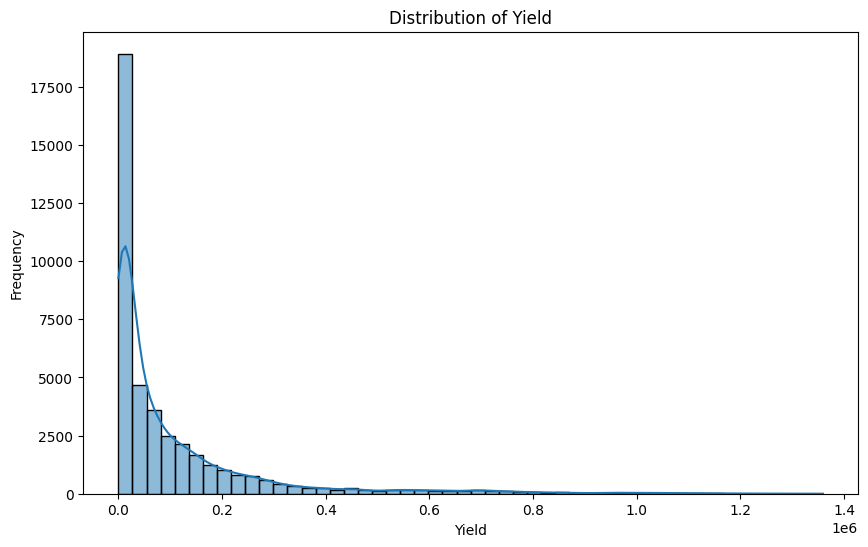

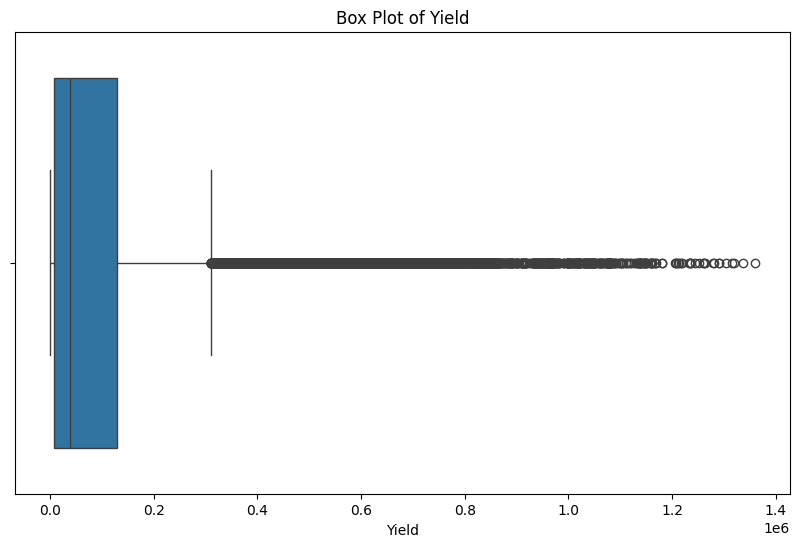

In [ ]:
# Visualize the distribution of 'Yield'
plt.figure(figsize=(10, 6))
sns.histplot(yield_data['Yield'], bins=50, kde=True)
plt.title('Distribution of Yield')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=yield_data['Yield'])
plt.title('Box Plot of Yield')
plt.xlabel('Yield')
plt.show()

In [ ]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df, column_name):
    """
    Remove outliers from a DataFrame using the IQR method.
    :param df: DataFrame containing the data
    :param column_name: Column name for which to remove outliers
    :return: DataFrame with outliers removed
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to remove outliers from 'yield'
yield_clean = remove_outliers_iqr(yield_data, 'Yield')

# Print the number of rows before and after outlier removal
print(f"Number of rows before outlier removal: {len(yield_data)}")
print(f"Number of rows after outlier removal: {len(yield_clean)}")

# Display the first few rows of the cleaned DataFrame
print(yield_clean.head())


Number of rows before outlier removal: 41649
Number of rows after outlier removal: 38078
          Area  Year  Yield                      Item
0  Afghanistan  2000   8063  Cereals and Preparations
1  Afghanistan  2001  10067  Cereals and Preparations
2  Afghanistan  2002  16698  Cereals and Preparations
3  Afghanistan  2003  14580  Cereals and Preparations
4  Afghanistan  2004  13348  Cereals and Preparations


In [ ]:
# Merging DataFrames on 'Year', 'Area', and 'Item'
merged_data = pd.merge(food_trade_clean, yield_clean, on=['Year', 'Area', 'Item'], how='inner')

# Verify the merge by checking the first few rows
print("First few rows of the final merged DataFrame:")
print(merged_data.head())

# Check for any null values in critical columns
print(merged_data.isnull().sum())

# Sample some rows to ensure the data looks as expected
print(merged_data.sample(5))


First few rows of the final merged DataFrame:
   Year         Area                      Item  Export Value  Import Value  \
0  2012  Afghanistan  Cereals and Preparations          0.00     372176.00   
1  2013  Afghanistan  Cereals and Preparations          0.00     419030.00   
2  2014  Afghanistan  Cereals and Preparations       1074.45     815313.48   
3  2015  Afghanistan  Cereals and Preparations        173.08     768582.62   
4  2016  Afghanistan  Cereals and Preparations        346.57     857806.46   

   Future Export Value  Export_Value_Lag_3  Yield  
0               173.08               15.00  20942  
1               346.57               54.00  21277  
2              1628.89                0.00  20966  
3               591.29                0.00  22064  
4              8996.17                0.00  20433  
Year                   0
Area                   0
Item                   0
Export Value           0
Import Value           0
Future Export Value    0
Export_Value_Lag_3     

                     Future Export Value  Yield
Future Export Value                 1.00   0.11
Yield                               0.11   1.00


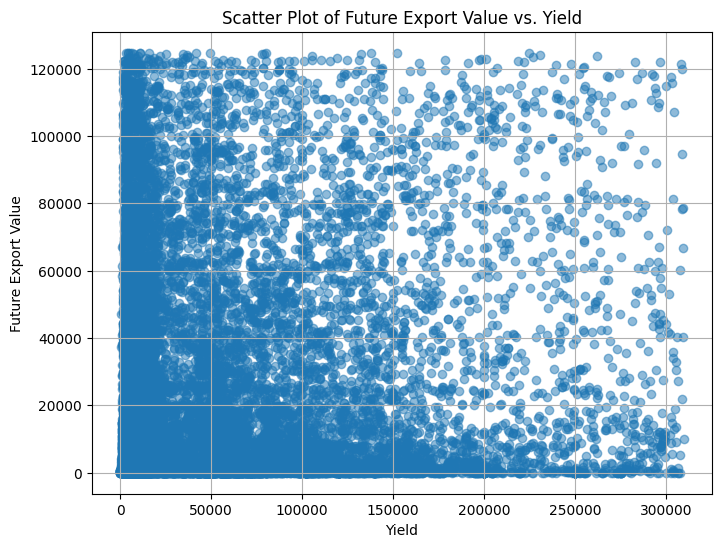

In [ ]:
# Calculate and visualize the correlation matrix between 'Future Export Value' and 'Yield'
correlation_matrix = merged_data[['Future Export Value','Yield']].corr()
print (correlation_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(merged_data['Yield'], merged_data['Future Export Value'], alpha=0.5)
plt.title('Scatter Plot of Future Export Value vs. Yield')
plt.xlabel('Yield')
plt.ylabel('Future Export Value')
plt.grid(True)
plt.show()



Fairly weak correltaion however will still be used as a feature based on domain knowledge.



## Exchange Rate

In [ ]:
print(exchange_rate.head())

print("\nSummary Statistics of crops_production_indicators:")
print(exchange_rate.describe())

print("Basic DataFrame Information:")
exchange_rate.info()

# Display the first few rows of the DataFrame
print("\nPreview of DataFrame:")
print(exchange_rate.head())

# Check for missing values across all columns
print("\nMissing Values Check:")
print(exchange_rate.isnull().sum())


  Domain Code          Domain  Area Code (M49)         Area  \
0          PE  Exchange rates                4  Afghanistan   
1          PE  Exchange rates                4  Afghanistan   
2          PE  Exchange rates                4  Afghanistan   
3          PE  Exchange rates                4  Afghanistan   
4          PE  Exchange rates                4  Afghanistan   

  ISO Currency Code (FAO) Currency Element Code                       Element  \
0                     AFA  Afghani          LCU  Local currency units per USD   
1                     AFA  Afghani          LCU  Local currency units per USD   
2                     AFA  Afghani          LCU  Local currency units per USD   
3                     AFA  Afghani          LCU  Local currency units per USD   
4                     AFA  Afghani          LCU  Local currency units per USD   

   Year Code  Year  Months Code    Months  Unit  Value Flag  \
0       1980  1980         7001   January   NaN  44.13    X   
1       

Feature engineering: AVERAGE EXCHANGE RATE PER YEAR

In [ ]:
yearly_avg_exchange_rates = exchange_rate.groupby(['Area', 'Year'])['Value'].mean().reset_index()

# Renaming for clarity
yearly_avg_exchange_rates.rename(columns={'Value': 'Yearly Average Exchange Rate'}, inplace=True)

# Displaying the DataFrame to verify
print(yearly_avg_exchange_rates)


               Area  Year  Yearly Average Exchange Rate
0       Afghanistan  1980                         44.13
1       Afghanistan  1981                         49.48
2       Afghanistan  1982                         50.60
3       Afghanistan  1983                         50.60
4       Afghanistan  1984                         50.60
...             ...   ...                           ...
8634  Åland Islands  2019                          0.89
8635  Åland Islands  2020                          0.88
8636  Åland Islands  2021                          0.85
8637  Åland Islands  2022                          0.95
8638  Åland Islands  2023                          0.92

[8639 rows x 3 columns]


CHECK FOR COMPATIBILITY

In [ ]:
print(yearly_avg_exchange_rates['Year'].unique())
print(merged_data['Year'].unique())

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023]
[2012 2013 2014 2015 2016 2017 2018 2019 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011]


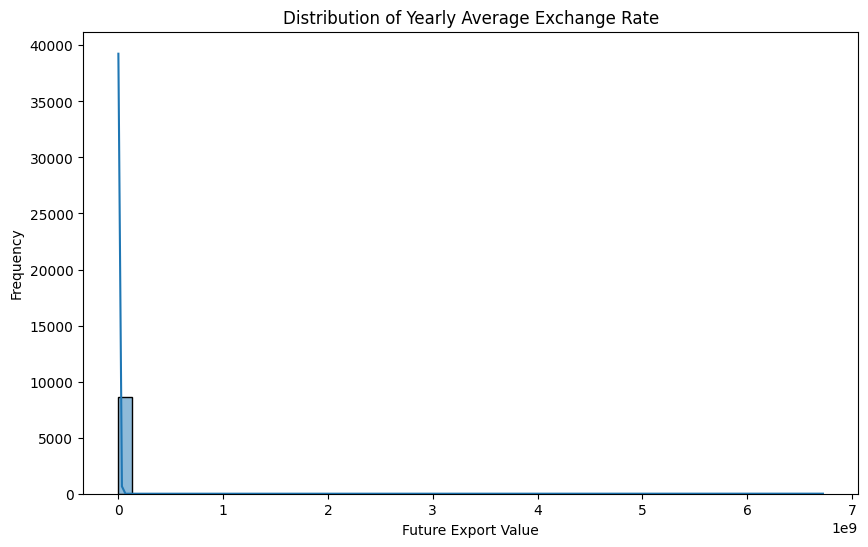

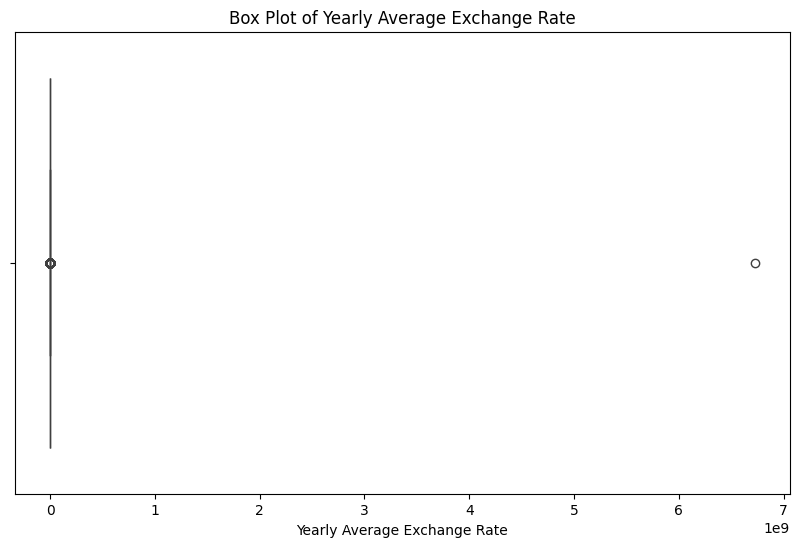

In [ ]:
# Visualize the distribution of 'Yearly Average Exchange Rate'
plt.figure(figsize=(10, 6))
sns.histplot(yearly_avg_exchange_rates['Yearly Average Exchange Rate'], bins=50, kde=True)
plt.title('Distribution of Yearly Average Exchange Rate')
plt.xlabel('Future Export Value')
plt.ylabel('Frequency')
plt.show()

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=yearly_avg_exchange_rates['Yearly Average Exchange Rate'])
plt.title('Box Plot of Yearly Average Exchange Rate')
plt.xlabel('Yearly Average Exchange Rate')
plt.show()

In [ ]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df, column_name):
    """
    Remove outliers from a DataFrame using the IQR method.
    :param df: DataFrame containing the data
    :param column_name: Column name for which to remove outliers
    :return: DataFrame with outliers removed
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to remove outliers from 'Yearly Average Exchange Rate'
exchange_rates_clean = remove_outliers_iqr(yearly_avg_exchange_rates, 'Yearly Average Exchange Rate')

# Print the number of rows before and after outlier removal
print(f"Number of rows before outlier removal: {len(yearly_avg_exchange_rates)}")
print(f"Number of rows after outlier removal: {len(exchange_rates_clean)}")

# Check the first few rows of the cleaned data
print(exchange_rates_clean.head())


Number of rows before outlier removal: 8639
Number of rows after outlier removal: 6990
          Area  Year  Yearly Average Exchange Rate
0  Afghanistan  1980                         44.13
1  Afghanistan  1981                         49.48
2  Afghanistan  1982                         50.60
3  Afghanistan  1983                         50.60
4  Afghanistan  1984                         50.60


   Year         Area                      Item  Export Value  Import Value  \
0  2012  Afghanistan  Cereals and Preparations          0.00     372176.00   
1  2012  Afghanistan                Other food      29169.00     285930.00   
2  2012  Afghanistan                Other food      29169.00     285930.00   
3  2012  Afghanistan                Other food      29169.00     285930.00   
4  2012  Afghanistan                Other food      29169.00     285930.00   

   Future Export Value  Export_Value_Lag_3   Yield  \
0               173.08               15.00   20942   
1             74089.46            21177.00    3850   
2             74089.46            21177.00    7989   
3             74089.46            21177.00  109524   
4             74089.46            21177.00   41416   

   Yearly Average Exchange Rate  
0                         50.92  
1                         50.92  
2                         50.92  
3                         50.92  
4                         50.92  
<c

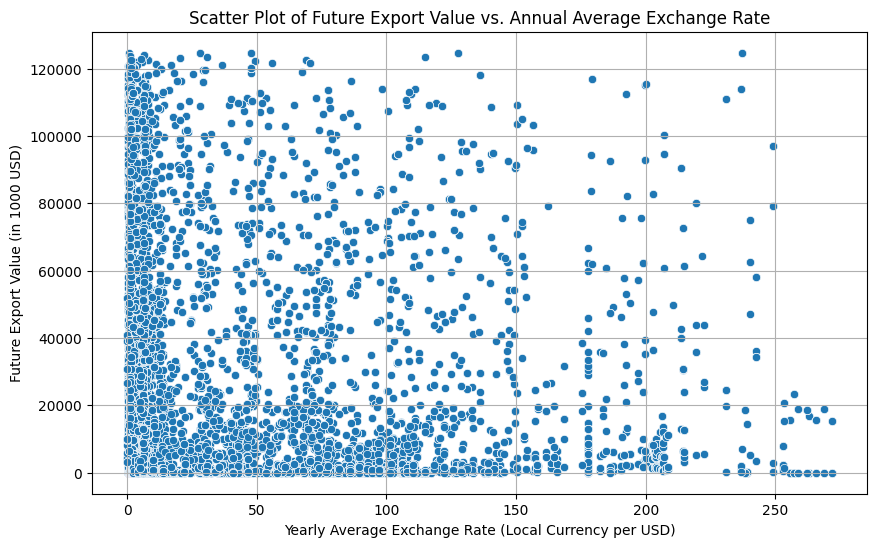

In [ ]:
# Merge the merged_data dataframe with the exchange_rates_clean dataframe
merged_data1 = pd.merge(merged_data, exchange_rates_clean, on=['Year', 'Area'], how='inner')

# Display the first few rows of the merged DataFrame to verify
print(merged_data1.head())

# Check for the number of entries and if there are any unexpected NaN values
print(merged_data1.info())


# Calculate correlation
correlation_matrix = merged_data1[['Yearly Average Exchange Rate', 'Future Export Value']].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Yearly Average Exchange Rate', y='Future Export Value', data=merged_data1)
plt.title('Scatter Plot of Future Export Value vs. Annual Average Exchange Rate')
plt.xlabel('Yearly Average Exchange Rate (Local Currency per USD)')
plt.ylabel('Future Export Value (in 1000 USD)')
plt.grid(True)
plt.show()



## Foreign Direct Investment


In [ ]:
# Display the first few rows of the DataFrame
print("Head of the dataset:")
print(foreign_investment.head())

# Display information about the DataFrame
print("\nDataFrame Info:")
foreign_investment.info()

# Display summary statistics of the DataFrame
print("\nSummary Statistics:")
print(foreign_investment.describe())


Head of the dataset:
  Domain Code                           Domain  Area Code (M49)         Area  \
0         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
1         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
2         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
3         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
4         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   

   Element Code    Element  Item Code               Item  Year Code  Year  \
0          6110  Value US$      23082  Total FDI inflows       2000  2000   
1          6110  Value US$      23082  Total FDI inflows       2001  2001   
2          6110  Value US$      23082  Total FDI inflows       2002  2002   
3          6110  Value US$      23082  Total FDI inflows       2003  2003   
4          6110  Value US$      23082  Total FDI inflows       2004  2004   

          Unit  Value Flag         

In [ ]:
# Count the occurrences of each category in the 'Item' column
item_counts = foreign_investment['Item'].unique()
print(item_counts)

['Total FDI inflows' 'Total FDI outflows'
 'FDI inflows to Agriculture, Forestry and Fishing'
 'FDI inflows to Food, Beverages and Tobacco'
 'FDI outflows to Agriculture, Forestry and Fishing'
 'FDI outflows to Food, Beverages and Tobacco']


In [ ]:
# Create separate columns for Total FDI Inflows
foreign_investment['Total FDI inflows'] = foreign_investment.apply(lambda x: x['Value'] if 'Total FDI inflows' in x['Item'] else None, axis=1)


# Display the modified DataFrame to check new columns
print("\nModified DataFrame with Total FDI Inflows columns:")
print(foreign_investment.head())

# Check for NaN values across the DataFrame
print("\nNaN Values in the DataFrame:")
print(foreign_investment.isnull().sum())




Modified DataFrame with Total FDI Inflows columns:
  Domain Code                           Domain  Area Code (M49)         Area  \
0         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
1         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
2         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
3         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
4         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   

   Element Code    Element  Item Code               Item  Year Code  Year  \
0          6110  Value US$      23082  Total FDI inflows       2000  2000   
1          6110  Value US$      23082  Total FDI inflows       2001  2001   
2          6110  Value US$      23082  Total FDI inflows       2002  2002   
3          6110  Value US$      23082  Total FDI inflows       2003  2003   
4          6110  Value US$      23082  Total FDI inflows       2004  2004   

    

In [ ]:
# Drop rows where 'Total FDI inflows' column has NaN values
foreign_investment = foreign_investment.dropna(subset=['Total FDI inflows'])

# Check the result to ensure the NaNs have been removed
print(foreign_investment['Total FDI inflows'].isnull().sum())  # Should print 0


0


CHECK FOR COMPATIBILITY

In [ ]:
print(foreign_investment['Year'].unique())
print(food_trade['Year'].unique())

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022]


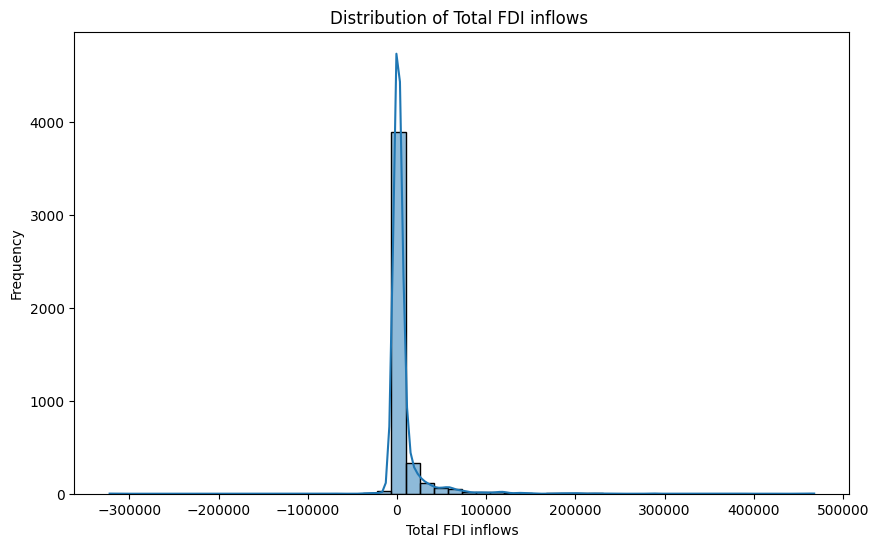

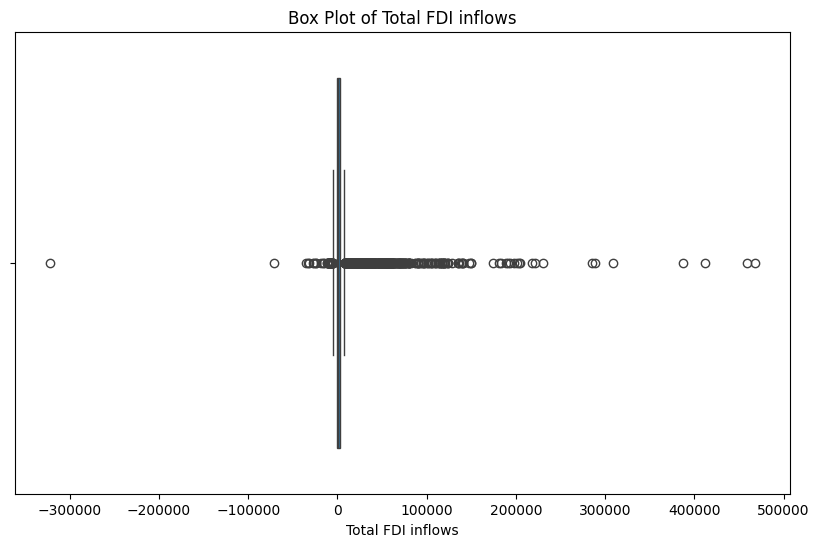

In [ ]:
# Visualize the distribution of 'Yearly Average Exchange Rate'
plt.figure(figsize=(10, 6))
sns.histplot(foreign_investment['Total FDI inflows'], bins=50, kde=True)
plt.title('Distribution of Total FDI inflows ')
plt.xlabel('Total FDI inflows')
plt.ylabel('Frequency')
plt.show()

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=foreign_investment['Total FDI inflows'])
plt.title('Box Plot of Total FDI inflows')
plt.xlabel('Total FDI inflows')
plt.show()


In [ ]:
# Performing the merge
merged_data2 = pd.merge(merged_data1, foreign_investment[['Area', 'Year', 'Total FDI inflows']],
                        on=['Area', 'Year'], how='left')

# Check the first few rows to confirm the merge
print("First few rows of the merged DataFrame:")
print(merged_data2.head())

print(merged_data2.isnull().sum())


First few rows of the merged DataFrame:
   Year         Area                      Item  Export Value  Import Value  \
0  2012  Afghanistan  Cereals and Preparations          0.00     372176.00   
1  2012  Afghanistan                Other food      29169.00     285930.00   
2  2012  Afghanistan                Other food      29169.00     285930.00   
3  2012  Afghanistan                Other food      29169.00     285930.00   
4  2012  Afghanistan                Other food      29169.00     285930.00   

   Future Export Value  Export_Value_Lag_3   Yield  \
0               173.08               15.00   20942   
1             74089.46            21177.00    3850   
2             74089.46            21177.00    7989   
3             74089.46            21177.00  109524   
4             74089.46            21177.00   41416   

   Yearly Average Exchange Rate  Total FDI inflows  
0                         50.92              40.86  
1                         50.92              40.86  
2      

In [ ]:
# Fill NaN values with zero
merged_data2['Total FDI inflows'].fillna(0, inplace=True)


print(merged_data2.isnull().sum())


Year                            0
Area                            0
Item                            0
Export Value                    0
Import Value                    0
Future Export Value             0
Export_Value_Lag_3              0
Yield                           0
Yearly Average Exchange Rate    0
Total FDI inflows               0
dtype: int64


                     Total FDI inflows  Future Export Value
Total FDI inflows                 1.00                 0.10
Future Export Value               0.10                 1.00


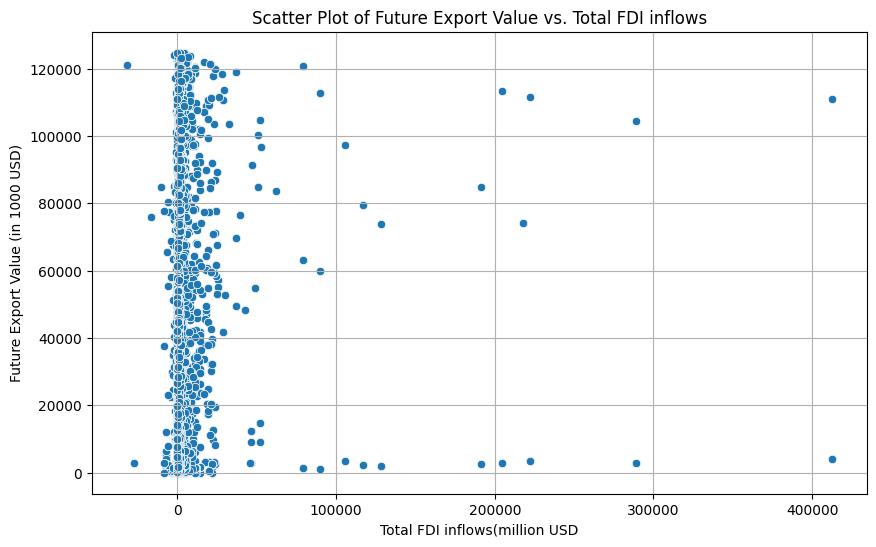

In [ ]:
# Calculate correlation between Total FDI inflows and target variable
correlation_matrix = merged_data2[['Total FDI inflows', 'Future Export Value']].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total FDI inflows', y='Future Export Value', data=merged_data2)
plt.title('Scatter Plot of Future Export Value vs. Total FDI inflows')
plt.xlabel('Total FDI inflows(million USD')
plt.ylabel('Future Export Value (in 1000 USD)')
plt.grid(True)
plt.show()



In [ ]:
# List of columns based on which to check for duplicates
columns_to_check = [
    'Export Value', 'Import Value',
     'Export_Value_Lag_3', 'Future Export Value', 'Yield',
    'Yearly Average Exchange Rate', 'Total FDI inflows'
]

# Drop duplicate rows based on the specified columns
final_data = merged_data2.drop_duplicates(subset=columns_to_check, keep='first')

# Print the shape of the DataFrame to confirm the number of rows after dropping duplicates
print(final_data.shape)

print(final_data.columns)

(12031, 10)
Index(['Year', 'Area', 'Item', 'Export Value', 'Import Value',
       'Future Export Value', 'Export_Value_Lag_3', 'Yield',
       'Yearly Average Exchange Rate', 'Total FDI inflows'],
      dtype='object')


In [ ]:
# Check for missing values in each column
missing_data = final_data.isnull().sum()
print(missing_data[missing_data > 0])


# Check data types of each column
print(final_data.dtypes)

# Check for duplicate rows
duplicates = final_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Series([], dtype: int64)
Year                              int64
Area                             object
Item                             object
Export Value                    float64
Import Value                    float64
Future Export Value             float64
Export_Value_Lag_3              float64
Yield                             int64
Yearly Average Exchange Rate    float64
Total FDI inflows               float64
dtype: object
Number of duplicate rows: 0


In [ ]:
print(final_data['Year'].unique())

[2012 2013 2014 2015 2016 2017 2018 2019 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2000 2001 2002]


## MODELLING: MLP REGRESSOR

MODEL FEATURES

*   Export Value
*   Import Value
*   Yield
*   Yearly Average Exchange Rate
*   Total FDI inflows
*   Year - represents specific periods in time.
*   Area - Represents different geographical locations.
*   Item - Types of products or categories.





HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH






*  Using smaller dataset for accelerated hyperparameter tuning




In [ ]:
# Calculate total export values by country
total_exports_by_country = final_data.groupby('Area')['Export Value'].sum().sort_values(ascending=False)

# Get the top 10 exporting countries
top_10_countries = total_exports_by_country.head(10).index.tolist()
print("Top 10 exporting countries:", top_10_countries)


# Filter the dataset to include only the top 10 exporting countries
final_data_top_10 = final_data[final_data['Area'].isin(top_10_countries)]

# Check the first few rows of the new DataFrame
print("Filtered data for top 10 exporting countries:")
print(final_data_top_10.head())


# Check for missing values in each column
missing_data = final_data_top_10.isnull().sum()
print(missing_data[missing_data > 0])

Top 10 exporting countries: ['Nepal', 'Bosnia and Herzegovina', 'Jamaica', 'Tunisia', 'Bolivia (Plurinational State of)', 'Uruguay', 'Belize', 'Namibia', 'Bangladesh', 'Switzerland']
Filtered data for top 10 exporting countries:
      Year        Area                              Item  Export Value  \
1152  2000  Bangladesh          Cereals and Preparations        708.00   
1153  2000  Bangladesh  Fats and Oils (excluding Butter)          0.00   
1154  2000  Bangladesh  Fats and Oils (excluding Butter)          0.00   
1155  2000  Bangladesh              Fruit and Vegetables      11428.00   
1156  2000  Bangladesh              Fruit and Vegetables      11428.00   

      Import Value  Future Export Value  Export_Value_Lag_3  Yield  \
1152     375498.00               696.00              163.00  33844   
1153     503275.00                23.00                0.00   4367   
1154     503275.00                23.00                0.00   2922   
1155     152273.00             14406.00       

In [ ]:
# Preprocessor setup
numeric_features = ['Import Value', 'Export Value', 'Yearly Average Exchange Rate', 'Yield', 'Total FDI inflows']
numeric_transformer = StandardScaler()

categorical_features = ['Year', 'Area', 'Item']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# MLP Regressor Setup (initial with default parameters)
mlp_regressor = MLPRegressor(activation='relu', solver='adam', max_iter=750, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', mlp_regressor)
])

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'regressor__hidden_layer_sizes': [(10, 4), (20, 8), (50, 25), (100, 50)],
    'regressor__alpha': [0.01, 0.1],
    'regressor__learning_rate_init': [0.001, 0.01]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=16, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

# Splitting data into train-validation sets and test set (80:20)
train_valid, test = train_test_split(final_data_top_10, test_size=0.2, random_state=42)

# Further split the train-validation set into training and validation sets (80:20)
train, validate = train_test_split(train_valid, test_size=0.2, random_state=42)

# Prepare feature matrices and target vectors
X_train = train.drop(['Future Export Value'], axis=1)
y_train = train['Future Export Value']
X_validate = validate.drop(['Future Export Value'], axis=1)
y_validate = validate['Future Export Value']
X_test = test.drop(['Future Export Value'], axis=1)
y_test = test['Future Export Value']

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the optimal parameters
print("Optimal parameters:", random_search.best_params_)

BUILDING, TESTING AND TRAINING MLP REGRESSOR

In [ ]:
# Preprocessor setup
numeric_features = ['Import Value', 'Export Value','Yearly Average Exchange Rate', 'Yield', 'Total FDI inflows']
numeric_transformer = StandardScaler()

categorical_features = ['Year', 'Area', 'Item']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# MLP Regressor Setup with optimal parameters
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50, ), activation='relu', solver='adam', alpha=0.01, learning_rate='constant', learning_rate_init=0.01, max_iter=750, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', mlp_regressor)
])

# Splitting data into train-validation sets and test set (80:20)
train_valid, test = train_test_split(final_data, test_size=0.2, random_state=42)

# Further split the train-validation set into training and validation sets (80:20)
train, validate = train_test_split(train_valid, test_size=0.2, random_state=42)

# Prepare feature matrices and target vectors
X_train = train.drop(['Future Export Value'], axis=1)
y_train = train['Future Export Value']
X_validate = validate.drop(['Future Export Value'], axis=1)
y_validate = validate['Future Export Value']
X_test = test.drop(['Future Export Value'], axis=1)
y_test = test['Future Export Value']

# Fit the model
pipeline.fit(X_train, y_train)

# Predict using the pipeline on the validation and test data
y_pred_validate = pipeline.predict(X_validate)
y_pred_test = pipeline.predict(X_test)

# Calculate metrics for the validation set
mse_val = mean_squared_error(y_validate, y_pred_validate)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_validate, y_pred_validate)
print(f"Validation MSE: {mse_val}, RMSE: {rmse_val}, MAE: {mae_val}")

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}")

# Combine predictions with the test data for final output
test_results = test.copy()
test_results['Predicted Future Export Value'] = y_pred_test
test_results['Actual Future Export Value'] = y_test  # This is here for comparison

# Add an ID column
test_results['Data Instance ID'] = test_results.index + 1

# Select and rename columns
output_df = test_results[['Data Instance ID', 'Year', 'Area', 'Item', 'Actual Future Export Value', 'Predicted Future Export Value']]
output_df.rename(columns={
    'Data Instance ID': 'ID',
    'Actual Future Export Value': 'True Label',
    'Predicted Future Export Value': 'Prediction'
}, inplace=True)

# Save to CSV
output_df.to_csv('model_predictions.csv', index=False)

# Print to check the output
print(output_df)

# Print the test results with additional details
print(test_results[['Year', 'Area', 'Item', 'Predicted Future Export Value', 'Actual Future Export Value']])


Validation MSE: 106435685.63020629, RMSE: 10316.767208297679, MAE: 4781.640848949815
Test MSE: 66908622.42185144, RMSE: 8179.769093431149, MAE: 4341.32683422274
          ID  Year                       Area  \
4412    4413  2017                     Gambia   
10473  10474  2019                  Sri Lanka   
5032    5033  2005                      Haiti   
2611    2612  2002  China, Taiwan Province of   
1562    1563  2008                     Belize   
...      ...   ...                        ...   
3206    3207  2001         Dominican Republic   
5718    5719  2008                   Kiribati   
11126  11127  2016                      Tonga   
735      736  2008        Antigua and Barbuda   
5875    5876  2019                     Kuwait   

                                   Item  True Label  Prediction  
4412               Fruit and Vegetables     1069.73    26385.58  
10473  Fats and Oils (excluding Butter)    94410.32    98992.73  
5032                         Other food    13253.00 

<ipython-input-46-23590f7ad3dd>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df.rename(columns={


In [ ]:
#Download Outputs (CSV)
from google.colab import files
files.download('model_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rmse = math.sqrt(mse_test) # Calculate RMSE from MSE
print(f"Validation RMSE: {rmse}")


# Calculate maximum, minimum, and standard deviation of 'Future Export Value'
max_value = final_data['Future Export Value'].max()
min_value = final_data['Future Export Value'].min()
std_dev = final_data['Future Export Value'].std()

print(f"Maximum Future Export Value: {max_value}")
print(f"Minimum Future Export Value: {min_value}")
print(f"Standard Deviation of Future Export Value: {std_dev}")


# Calculate the range of 'Future Export Value'
range_value = max_value - min_value
print(f"Range of Future Export Value: {range_value}")

# Compare RMSE to Range and Standard Deviation
print(f"Comparison of RMSE to Range: RMSE is {'higher' if rmse > range_value else 'lower'} than the range of Future Export Value.")
print(f"Comparison of RMSE to Standard Deviation: RMSE is {'higher' if rmse > std_dev else 'lower'} than the standard deviation of Future Export Value.")




Validation RMSE: 8179.769093431149
Maximum Future Export Value: 124688.0
Minimum Future Export Value: 0.0
Standard Deviation of Future Export Value: 32777.53950461076
Range of Future Export Value: 124688.0
Comparison of RMSE to Range: RMSE is lower than the range of Future Export Value.
Comparison of RMSE to Standard Deviation: RMSE is lower than the standard deviation of Future Export Value.
